In [216]:
import numpy as np
import matplotlib.pyplot as plt

In [217]:
from src import FTBS, FTCS, crafted_solution, L1_error, FTBS_2

### Rozwiązanie numeryczne modelu Payne'a-Whithama

#### Parametry (do dopasowania)

In [218]:
N = 40
T = 100
h = 0.25 # w kilometrach
k = h/150 # w godzinach
rho_max = 20
v_max = 100
tau = 0.1
chi = 120
c0 = 350
l = 3
m = 1.8

In [219]:
space = np.linspace(0, h*N, N+1)
time = np.linspace(0, k*T, T+1)

#### Warunki początkowe (do dopasowania)

In [220]:
init_rho = 5 + 3*np.exp((-(space - 7)**2)/5)
init_v = v_max*(1 - init_rho/rho_max)

#### Warunki brzegowe (do dopasowania)

In [221]:
bound_rho_1 = np.ones(T+1)*init_rho[0]
bound_v_1 = np.ones(T+1)*init_v[0]
bound_rho_2 = np.ones(T+1)*init_rho[N]
bound_v_2 = np.ones(T+1)*init_v[N]

#### Rozwiązanie schematem pierwszym

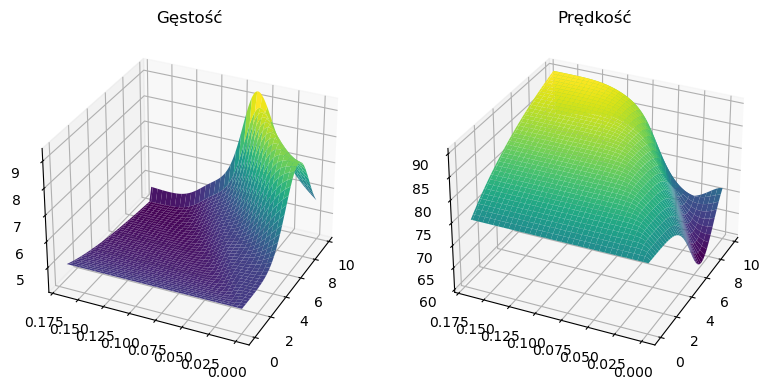

In [222]:
r, v, c = FTBS((init_rho, init_v), (bound_rho_1, bound_v_1), k, h, rho_max, v_max, tau, chi, c0, l, m)

#### Rozwiązanie schematem drugim

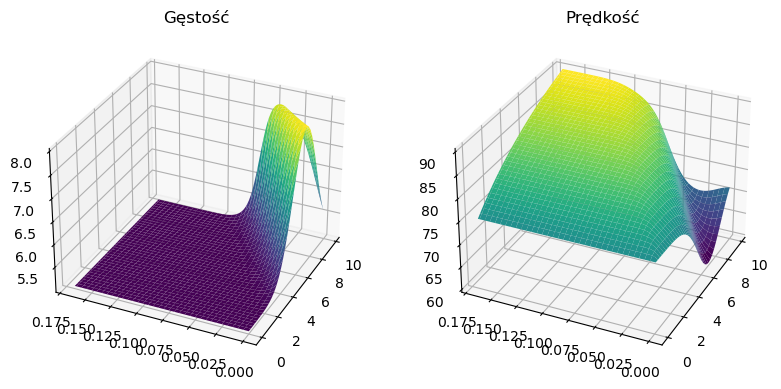

In [223]:
r, v, c = FTBS_2((init_rho, init_v), (bound_rho_1, bound_v_1), k, h, rho_max, v_max, tau, chi, c0, l, m)

#### Rozwiązanie schematem symetrycznym

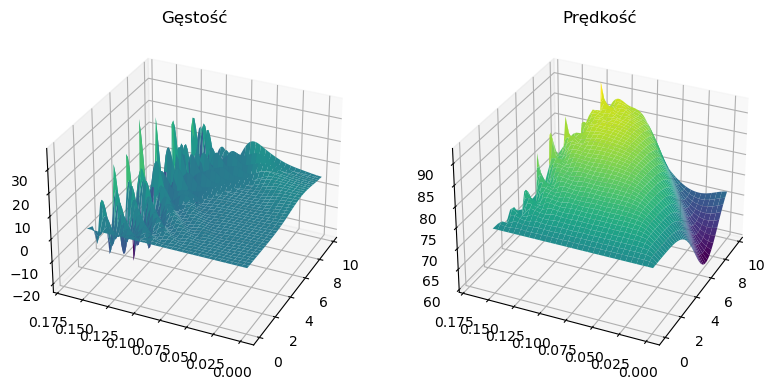

In [224]:
r, v, c = FTCS((init_rho, init_v), (bound_rho_1, bound_rho_2, bound_v_1, bound_v_2), k, h, rho_max, v_max, tau, chi, c0, l, m)

### Testy

Rozwiązanie sztuczne:

\begin{align*}
\rho(x, t) = 20 - \frac{(x - 8)^2}{12} - \frac{(t - 0.15)^2}{0.0016}\\
\rho_{max} = 20, v_{max} = 100\\
v(x, t) = v_{max}(1 - \frac{\rho}{\rho_{max}}) = 5\left[\frac{(x - 8)^2}{12} + \frac{(t - 0.15)^2}{0.0016}\right]
\end{align*}

In [225]:
N = 10
T = 30
k = 1/180 # w godzinach
h = 1 # w kilometrach
rho_max = 20
v_max = 100
tau = 0.1
chi = 120
c0 = 350
l = 1
m = 1

In [226]:
space = np.linspace(0, h*N, N+1)
time = np.linspace(0, k*T, T+1)

#### Wizualizacja sztucznego rozwiązania

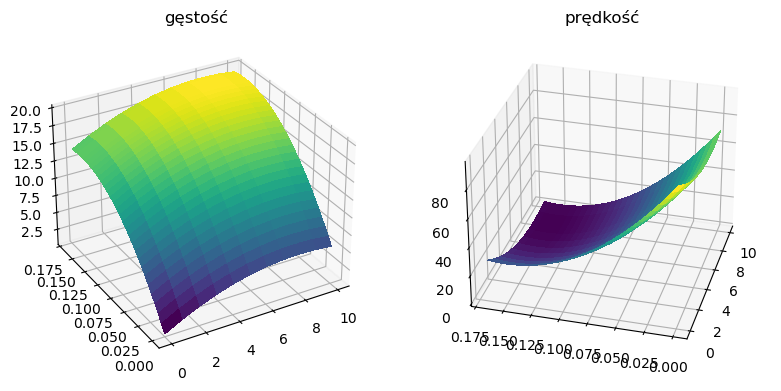

In [227]:
S, T = np.meshgrid(space, time)
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

U = 20 -(S - 8)**2/12 - (T - 0.15)**2/0.0016
V = 100*(1 - U/20)
ax.plot_surface(S, T, U, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0, antialiased=False)
ax.view_init(elev=30, azim=-120)
ax.set_title('gęstość')

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(S, T, V, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0, antialiased=False)
ax.view_init(elev=30, azim=-165)
ax.set_title('prędkość')

plt.show()

#### Wizualizacja rozwiązania dopasowanym schematem

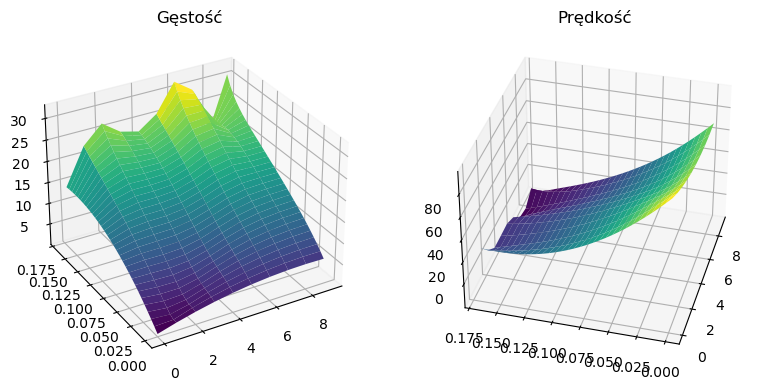

In [228]:
rho, v, cfl = crafted_solution((U[0, :], V[0, :]), (U[:, 0], V[:, 0]), k, h, rho_max, v_max, tau, chi, c0, l, m)

#### Błąd rozwiązania w normie $L_1$

In [229]:
print("Błąd rozwiązania dla gęstości wynosi w przybliżeniu " + str(round(L1_error(U, rho.transpose(), h, k), 3)))
print("Błąd rozwiązania dla prędkości wynosi w przybliżeniu " + str(round(L1_error(V[:, 0:-1], v.transpose(), h, k), 3)))

Błąd rozwiązania dla gęstości wynosi w przybliżeniu 7.685
Błąd rozwiązania dla prędkości wynosi w przybliżeniu 5.471


#### Porównanie błędów dla różnych wartości $k$ i $h$

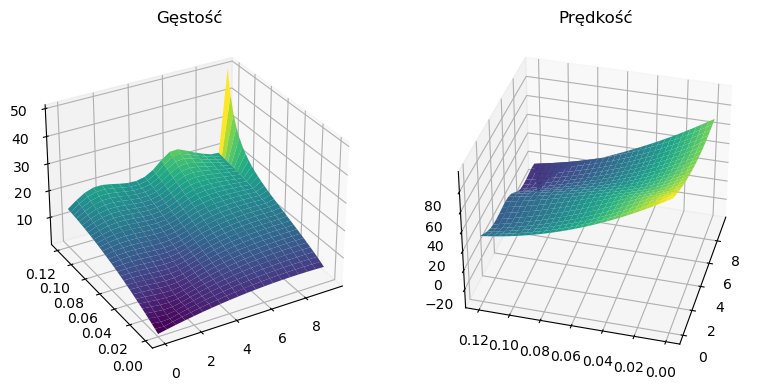

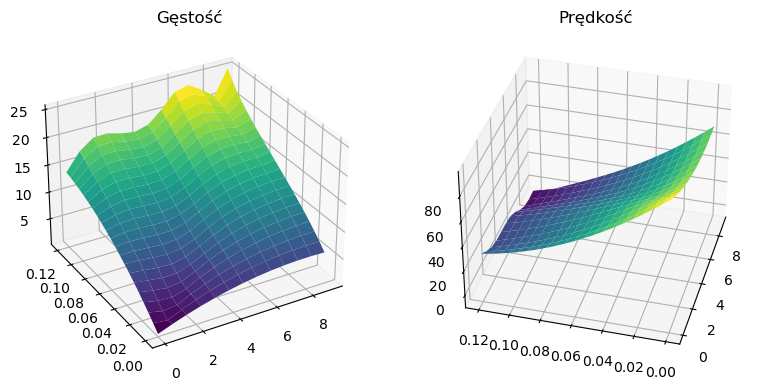

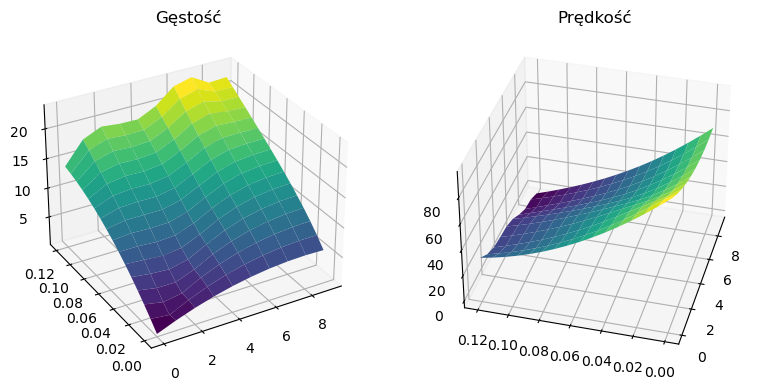

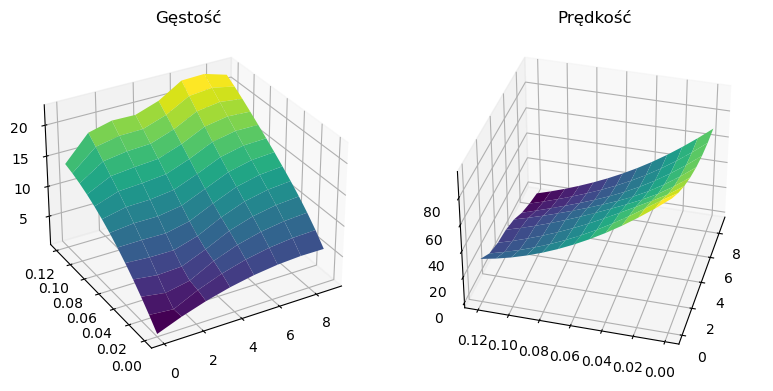

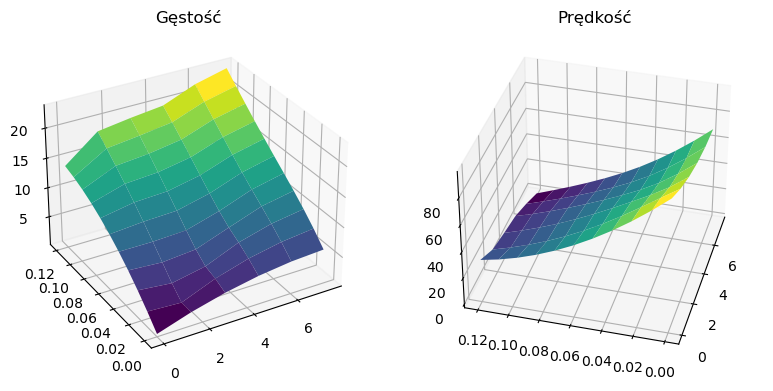

In [230]:
from math import floor
h_test = np.arange(0.5, 1.6, 0.25)
errors_rho = []
errors_v = []
point_errors_t1 = []
point_errors_t2 = []
for i in range(len(h_test)):
    h = h_test[i]
    k = h/125
    space = np.arange(0, 10 + 0.01, h)
    time = np.arange(0, 0.12 + 0.0001, k)
    half_time = int(floor((len(time)-1)/2))
    S, T = np.meshgrid(space, time)
    U = 20 -(S - 8)**2/12 - (T - 0.15)**2/0.0016
    V = 100*(1 - U/20)
    rho, v, cfl = crafted_solution((U[0, :], V[0, :]), (U[:, 0], V[:, 0]), k, h, rho_max, v_max, tau, chi, c0, l, m)
    errors_rho.append(L1_error(U[:, 0:-1], rho.transpose()[:, 0:-1], h, k))
    errors_v.append(L1_error(V[:, 0:-2], v.transpose()[:, 0:-1], h, k))
    point_errors_t1.append(np.abs(U[half_time, :] - rho.transpose()[half_time, :]))
    point_errors_t2.append(np.abs(U[-1, :] - rho.transpose()[-1, :]))

t1 = time[half_time]
t2 = time[-1] 

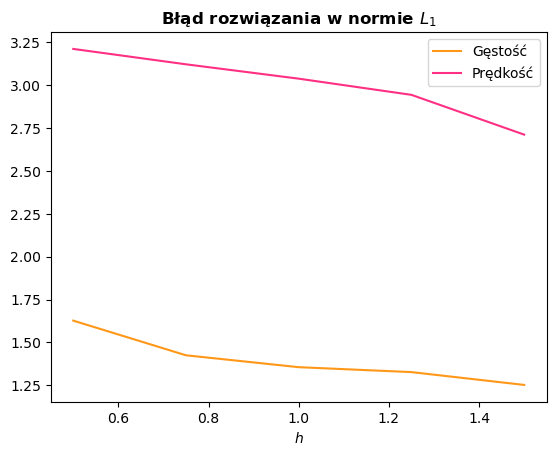

In [231]:
colors = ["#FF9719", "#1EC14E", "#FF3083", "#01FBFF", "#B632FF"]
plt.plot(h_test, errors_rho, label="Gęstość", color=colors[0])
plt.plot(h_test, errors_v, label="Prędkość", color=colors[2])
plt.title("Błąd rozwiązania w normie $L_1$", fontweight="bold")
plt.xlabel("$h$", fontweight="bold")
plt.legend()
plt.show()

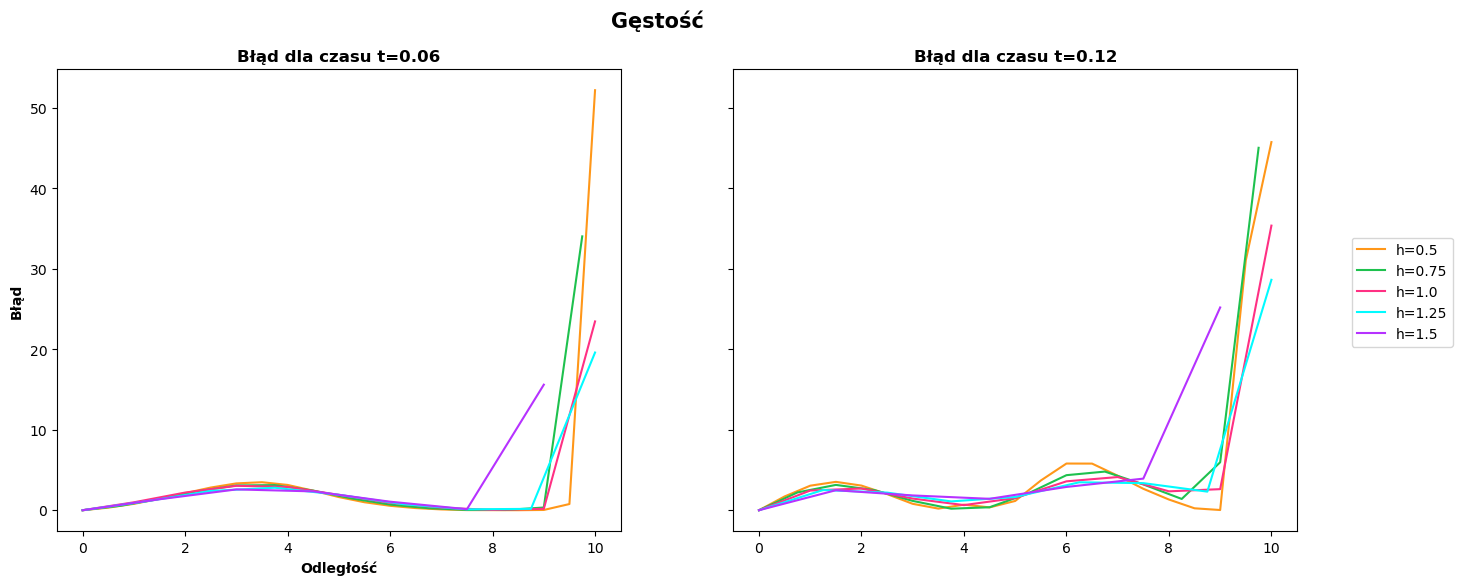

In [232]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.suptitle("Gęstość", fontsize=15, fontweight="bold")
for i in range(len(point_errors_t1)):
    ax[0].plot(np.arange(0, 10 + 0.01, h_test[i]), point_errors_t1[i], label="h=" + str(h_test[i]), color=colors[i])
    ax[1].plot(np.arange(0, 10 + 0.01, h_test[i]), point_errors_t2[i], color=colors[i])
ax[0].set_title("Błąd dla czasu t=" + str(t1), fontsize=12, fontweight="bold")
ax[0].set_xlabel("Odległość", fontweight="bold")
ax[0].set_ylabel("Błąd", fontweight="bold")

ax[1].set_title("Błąd dla czasu t=" + str(t2), fontsize=12, fontweight="bold")
ax[1].set_label("Odległość")

fig.legend(loc="center right")
plt.show()